In [ ]:
#
# Dependencies preparation
#
!python --version
!pip install "numpy<2.0"
!pip install scipy
!apt-get install libsuitesparse-dev
!pip install scikit-sparse
!pip install symforce
!pip install matplotlib
!pip install plotly

Python 3.10.12
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libamd2 libbtf1 libcamd2 libccolamd2 libcholmod3 libcolamd2 libcxsparse3 libgraphblas-dev
  libgraphblas6 libklu1 libldl2 libmetis5 libmongoose2 librbio2 libsliplu1 libspqr2
  libsuitesparseconfig5 libumfpack5
The following NEW packages will be installed:
  libamd2 libbtf1 libcamd2 libccolamd2 libcholmod3 libcolamd2 libcxsparse3 libgraphblas-dev
  libgraphblas6 libklu1 libldl2 libmetis5 libmongoose2 librbio2 libsliplu1 libspqr2
  libsuitesparse-dev libsuitesparseconfig5 libumfpack5
0 upgraded, 19 newly installed, 0 to remove and 49 not upgraded.
Need to get 22.4 MB of archives.
After this operation, 169 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 libsuitesparseconfig5 amd64 1:5.10.1+dfsg-4build1 [10.4 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 liba

In [ ]:
# To prepare the dataset files, clone
!git clone https://github.com/gisbi-kim/nano-pgo.git
!git checkout d73efd6d2f10e8f2be97bd93b565d9c0ff297fc4
%cd nano-pgo

Cloning into 'nano-pgo'...
remote: Enumerating objects: 406, done.
remote: Counting objects: 100% (129/129), done.
remote: Compressing objects: 100% (92/92), done.
remote: Total 406 (delta 70), reused 82 (delta 37), pack-reused 277 (from 1)
Receiving objects: 100% (406/406), 30.74 MiB | 8.60 MiB/s, done.
Resolving deltas: 100% (198/198), done.
fatal: not a git repository (or any of the parent directories): .git


In [ ]:
#
# prepare some from-scratch library codes
#

import shutil
import importlib.util
import os

import time
import numpy as np

np.set_printoptions(linewidth=np.inf, suppress=True, precision=4)
from scipy.spatial.transform import Rotation

import scipy.sparse as sp
import sksparse.cholmod as cholmod

import sym
import symforce

symforce.set_epsilon_to_number()
import symforce.symbolic as sf
from symforce.ops import LieGroupOps
from symforce import codegen
from symforce.values import Values
from symforce.codegen import codegen_util

import matplotlib.pyplot as plt
import plotly.graph_objects as go

import multiprocessing

import time
import functools


def timeit(func):
    TIMEIT_ENABLED = False

    @functools.wraps(func)
    def wrapper_timeit(*args, **kwargs):
        if TIMEIT_ENABLED:
            start_time = time.perf_counter()
            result = func(*args, **kwargs)
            end_time = time.perf_counter()
            elapsed_time = end_time - start_time
            print(f"[{func.__name__}] Time cost: {elapsed_time:.6f} sec.")
            return result
        else:
            return func(*args, **kwargs)

    return wrapper_timeit


def quat_to_rotmat(qx, qy, qz, qw):
    rotation = Rotation.from_quat([qx, qy, qz, qw])
    return rotation.as_matrix()


def rotvec_to_quat(rotvec):
    rotation = Rotation.from_rotvec(rotvec)
    q = rotation.as_quat()
    return q


def rotmat_to_rotvec(R):
    rotation = Rotation.from_matrix(R)
    rotvec = rotation.as_rotvec()
    return rotvec


def rotvec_to_rotmat(rotvec):
    rotation = Rotation.from_rotvec(rotvec)
    R = rotation.as_matrix()
    return R


def skew_symmetric(v):
    return np.array([[0, -v[2], v[1]], [v[2], 0, -v[0]], [-v[1], v[0], 0]])


def se2_to_se3(x, y, theta):
    rotation = Rotation.from_euler("z", theta)
    R = rotation.as_matrix()
    t = np.array([x, y, 0.0])
    return R, t


def plot_two_poses_with_edges_plotly(
    initial_poses_list,
    optimized_poses_list,
    edges,
    iteration_name="",
    skip=1,
):
    """
    Visualizes initial and optimized poses along with edges using Plotly with equal axis scaling.

    Parameters:
        initial_poses_list (list of np.ndarray): List of initial pose translations (3D positions).
        optimized_poses_list (list of np.ndarray): List of optimized pose translations (3D positions).
        edges (list of dict): List of edges, where each edge contains "i", "j" for the indices.
        skip (int, optional): Plot every 'skip' poses (default is 1, which plots all poses).
    """

    # Prepare poses for plotting
    initial_poses_np = np.array(
        [pose for idx, pose in enumerate(initial_poses_list) if idx % skip == 0]
    )
    optimized_poses_np = np.array(
        [pose for idx, pose in enumerate(optimized_poses_list) if idx % skip == 0]
    )

    # Create a scatter plot for initial and optimized poses
    trace_initial = go.Scatter3d(
        x=initial_poses_np[:, 0],
        y=initial_poses_np[:, 1],
        z=initial_poses_np[:, 2],
        mode="markers",
        marker=dict(size=5, color="red"),
        name="Initial Poses",
    )

    trace_optimized = go.Scatter3d(
        x=optimized_poses_np[:, 0],
        y=optimized_poses_np[:, 1],
        z=optimized_poses_np[:, 2],
        mode="markers",
        marker=dict(size=5, color="green"),
        name="Optimized Poses",
    )

    # Create lines for edges
    edge_traces = []
    for edge in edges:
        from_idx = edge["i"]
        to_idx = edge["j"]

        if from_idx < len(optimized_poses_list) and to_idx < len(optimized_poses_list):
            # Extract positions for the line
            x_vals = [
                optimized_poses_list[from_idx][0],
                optimized_poses_list[to_idx][0],
            ]
            y_vals = [
                optimized_poses_list[from_idx][1],
                optimized_poses_list[to_idx][1],
            ]
            z_vals = [
                optimized_poses_list[from_idx][2],
                optimized_poses_list[to_idx][2],
            ]

            edge_trace = go.Scatter3d(
                x=x_vals,
                y=y_vals,
                z=z_vals,
                mode="lines",
                line=dict(color="blue", width=2),
                showlegend=False,  # Don't show edges in the legend
            )
            edge_traces.append(edge_trace)

    # Combine all poses to calculate axis ranges
    all_points = np.vstack((initial_poses_np, optimized_poses_np))
    x_range = [all_points[:, 0].min(), all_points[:, 0].max()]
    y_range = [all_points[:, 1].min(), all_points[:, 1].max()]
    z_range = [all_points[:, 2].min(), all_points[:, 2].max()]

    # Calculate the overall range for equal axes
    max_range = max(
        x_range[1] - x_range[0], y_range[1] - y_range[0], z_range[1] - z_range[0]
    )
    x_mid = np.mean(x_range)
    y_mid = np.mean(y_range)
    z_mid = np.mean(z_range)

    # Set new ranges to make axes equal
    x_range = [x_mid - max_range / 2, x_mid + max_range / 2]
    y_range = [y_mid - max_range / 2, y_mid + max_range / 2]
    z_range = [z_mid - max_range / 2, z_mid + max_range / 2]

    # Combine all traces
    fig = go.Figure(data=[trace_initial, trace_optimized] + edge_traces)

    # Update layout with equal axis scaling
    fig.update_layout(
        title=f"{iteration_name}: Initial and Optimized Poses with Edges (Equal Axes)",
        scene=dict(
            xaxis=dict(title="X", range=x_range),
            yaxis=dict(title="Y", range=y_range),
            zaxis=dict(title="Z", range=z_range),
            aspectmode="cube",  # Ensures the aspect ratio is equal for all axes
        ),
        showlegend=True,
        width=1200,
        height=800,
    )

    # Show the plot
    fig.show()


def plot_two_poses_with_edges_open3d(
    initial_poses_list, optimized_poses_list, edges, skip=1
):
    """
    Visualizes initial and optimized poses along with edges using Open3D.

    Parameters:
        initial_poses_list (list of np.ndarray): List of initial pose translations (3D positions).
        optimized_poses_list (list of np.ndarray): List of optimized pose translations (3D positions).
        edges (list of dict): List of edges, where each edge contains "i", "j" for the indices.
        skip (int, optional): Plot every 'skip' poses (default is 1, which plots all poses).
    """

    import open3d as o3d

    def poses_to_point_cloud(pose_list, color, skip=1):
        points = [pose for idx, pose in enumerate(pose_list) if idx % skip == 0]
        points_np = np.array(points)

        # Create Open3D point cloud
        pcd = o3d.geometry.PointCloud()
        pcd.points = o3d.utility.Vector3dVector(points_np)

        # Set point colors
        colors_np = np.tile(color, (points_np.shape[0], 1))
        pcd.colors = o3d.utility.Vector3dVector(colors_np)

        return pcd

    # Create two point clouds with different colors
    pcd_initial = poses_to_point_cloud(
        initial_poses_list, color=[1, 0, 0], skip=skip
    )  # Red for initial poses
    pcd_optimized = poses_to_point_cloud(
        optimized_poses_list, color=[0, 1, 0], skip=skip
    )  # Green for optimized poses

    # Create lines for edges between poses
    lines = []
    line_colors = []

    for edge in edges:
        from_idx = edge["i"]
        to_idx = edge["j"]

        # Only plot edges if indices are valid
        if from_idx < len(optimized_poses_list) and to_idx < len(optimized_poses_list):
            # Line connects the from and to poses
            line = [from_idx, to_idx]
            lines.append(line)
            line_colors.append([0, 0, 1])  # Blue color for the lines

    # Create Open3D LineSet for the edges
    if lines:
        # Creates a LineSet object to represent edges between poses.
        # Use the points from the optimized poses as vertices
        line_set = o3d.geometry.LineSet()
        points = np.array(optimized_poses_list)
        line_set.points = o3d.utility.Vector3dVector(points)
        line_set.lines = o3d.utility.Vector2iVector(lines)
        line_set.colors = o3d.utility.Vector3dVector(line_colors)
    else:
        line_set = None

    # Visualize both point clouds, lines, and axes
    geometries = [pcd_initial, pcd_optimized]
    if line_set:
        geometries.append(line_set)

    o3d.visualization.draw_geometries(
        geometries,
        zoom=0.8,
        front=[0, 0, 1],  # top view
        lookat=initial_poses_list[-1],
        up=[0, 1, 0],
    )


#
# TODO: make these non-global (but must be called "once")
#

epsilon = 1e-7

# Define rotation variables (rotation vectors for each axis)
sf_ri = sf.V3.symbolic("ri")  # Rotation of pose_i
sf_rj = sf.V3.symbolic("rj")  # Rotation of pose_j
sf_rij = sf.V3.symbolic("rij")  # Measured relative rotation

# Define translation variables
sf_ti = sf.V3.symbolic("ti")  # Translation of pose_i
sf_tj = sf.V3.symbolic("tj")  # Translation of pose_j
sf_tij = sf.V3.symbolic("tij")  # Measured relative translation

# Create rotation matrices using Lie Group operations
sf_Ri = LieGroupOps.from_tangent(sf.Rot3, sf_ri)
sf_Rj = LieGroupOps.from_tangent(sf.Rot3, sf_rj)
sf_Rij = LieGroupOps.from_tangent(sf.Rot3, sf_rij)

# Construct SE(3) containers
sf_Ti = sf.Pose3(R=sf_Ri, t=sf_ti)
sf_Tj = sf.Pose3(R=sf_Rj, t=sf_tj)
sf_Tij = sf.Pose3(R=sf_Rij, t=sf_tij)

# SE3 error: T_err = T_ij^{-1} * T_i^{-1} * T_j
sf_T_err = sf_Tij.inverse() * (sf_Ti.inverse() * sf_Tj)

# Convert SE3 error to a tangent vector [r, t], 6-dim.
#  NOTE: symforce uses the [r, t] order, not [t, r].
sf_se3_err = sf.Matrix(sf_T_err.to_tangent())

# Define residual as the rotation and translation error
sf_residual = sf_se3_err  # 6D vector

# Compute the full Jacobian
sf_J_ti = sf_residual.jacobian([sf_ti])  # 6 x 3
sf_J_ri = sf_residual.jacobian([sf_ri])  # 6 x 3
sf_J_tj = sf_residual.jacobian([sf_tj])  # 6 x 3
sf_J_rj = sf_residual.jacobian([sf_rj])  # 6 x 3


def sf_between_error(Ti: sf.Pose3, Tj: sf.Pose3, Tij: sf.Pose3):
    return Tij.inverse() * (Ti.inverse() * Tj)


between_error_codegen = codegen.Codegen.function(
    func=sf_between_error,
    config=codegen.PythonConfig(),
)

between_error_codegen_with_jacobians = between_error_codegen.with_jacobians(
    which_args=["Ti", "Tj"],
    include_results=True,
)

between_error_codegen_with_jacobians_data = (
    between_error_codegen_with_jacobians.generate_function()
)

print(
    "\nThe optimized (compiled) Jacobian source files generated in {}:\n".format(
        between_error_codegen_with_jacobians_data.output_dir
    )
)

# copy here and import it
for f in between_error_codegen_with_jacobians_data.generated_files:
    rel_path = f.relative_to(between_error_codegen_with_jacobians_data.output_dir)

    gen_src_path = str(f)

    if not gen_src_path.endswith("__init__.py"):
        # Generate a new file name (__between_error_codegen.py)
        target_path = os.path.join(os.getcwd(), "__between_error_codegen.py")

        # Copy the file
        shutil.copyfile(gen_src_path, target_path)
        print(f"File copied to: {target_path}")

        # Import the copied file
        spec = importlib.util.spec_from_file_location(
            "__between_error_codegen", target_path
        )
        mod = importlib.util.module_from_spec(spec)
        spec.loader.exec_module(mod)

        # Import all functions from the module
        globals().update(
            {
                name: getattr(mod, name)
                for name in dir(mod)
                if callable(getattr(mod, name))
            }
        )
        print(f"Imported functions from: {target_path}")


@timeit
def between_factor_jacobian_by_symforce(pose_i, pose_j, pose_ij_meas):
    """
    Computes the Jacobians for the between factor residual using Symforce symbolic computation.

    Parameters:
        pose_i (dict): Dictionary containing rotation vector 'r' and translation 't' for pose i.
        pose_j (dict): Dictionary containing rotation vector 'r' and translation 't' for pose j.
        pose_ij_meas (dict): Dictionary containing the measured relative rotation matrix 'R' and translation vector 't'.

    Returns:
        Ji (np.ndarray): 6x6 Jacobian matrix with respect to pose i.
        Jj (np.ndarray): 6x6 Jacobian matrix with respect to pose j.

    Note: the Ji and Jj should have shapes (6, 6) like:
                                        |  translation_variable (3-dim), rotation_variable (3-dim) |
            cost_func_translation_part  |               *                          *               |
            cost_func_rotation_part     |               *                          *               |
    """

    using_optimized_compiled_one = True  # recommend to use True

    # fast
    if using_optimized_compiled_one:
        # Using the above auto-geneated functions within the copied __between_error_codegen.py file.
        _, res_D_Ti, res_D_Tj = sf_between_error_with_jacobians01(
            Ti=sym.Pose3(R=sym.rot3.Rot3(rotvec_to_quat(pose_i["r"])), t=pose_i["t"]),
            Tj=sym.Pose3(R=sym.rot3.Rot3(rotvec_to_quat(pose_j["r"])), t=pose_j["t"]),
            Tij=sym.Pose3(
                R=sym.rot3.Rot3(rotvec_to_quat(pose_ij_meas["r"])),
                t=pose_ij_meas["t"],
            ),
        )

        # ps. the reason why the index 3: mapped to :3
        # is because this example uses [t, r], but symforce uses the order of [r, t]
        sf_Ji = np.zeros((6, 6))
        sf_Ji[:3, :3] = res_D_Ti[3:, 3:]
        sf_Ji[3:, :3] = res_D_Ti[:3, 3:]
        sf_Ji[:3, 3:] = res_D_Ti[3:, :3]
        sf_Ji[3:, 3:] = res_D_Ti[:3, :3]

        sf_Jj = np.zeros((6, 6))
        sf_Jj[:3, :3] = res_D_Tj[3:, 3:]
        sf_Jj[3:, :3] = res_D_Tj[:3, 3:]
        sf_Jj[:3, 3:] = res_D_Tj[3:, :3]
        sf_Jj[3:, 3:] = res_D_Tj[:3, :3]

        # a verbose for debug or education,
        #  to compare with the hand-written, and the non-optimized Jacobians.
        if False:
            print("Jacobian wrt Ti:\n", sf_Jj)
            print("Jacobian wrt Tj:\n", sf_Jj)

        return sf_Ji, sf_Jj

    # slow
    else:
        # Create the substitutions dictionary
        substitutions = {
            sf_ri: sf.V3(pose_i["r"] + epsilon),
            sf_ti: sf.V3(pose_i["t"] + epsilon),
            sf_rj: sf.V3(pose_j["r"] + epsilon),
            sf_tj: sf.V3(pose_j["t"] + epsilon),
            sf_rij: sf.V3(pose_ij_meas["r"] + epsilon),
            sf_tij: sf.V3(pose_ij_meas["t"] + epsilon),
        }

        sf_J_ti_val = sf_J_ti.subs(substitutions).to_numpy()
        sf_J_ri_val = sf_J_ri.subs(substitutions).to_numpy()
        sf_J_tj_val = sf_J_tj.subs(substitutions).to_numpy()
        sf_J_rj_val = sf_J_rj.subs(substitutions).to_numpy()

        # ps. the reason why the index 3: mapped to :3
        # is because this example uses [t, r], but symforce uses the order of [r, t]
        sf_Ji = np.zeros((6, 6))
        sf_Ji[:3, :3] = sf_J_ti_val[3:, :]
        sf_Ji[3:, :3] = sf_J_ti_val[:3, :]
        sf_Ji[:3, 3:] = sf_J_ri_val[3:, :]
        sf_Ji[3:, 3:] = sf_J_ri_val[:3, :]

        sf_Jj = np.zeros((6, 6))
        sf_Jj[:3, :3] = sf_J_tj_val[3:, :]
        sf_Jj[3:, :3] = sf_J_tj_val[:3, :]
        sf_Jj[:3, 3:] = sf_J_rj_val[3:, :]
        sf_Jj[3:, 3:] = sf_J_rj_val[:3, :]

        return sf_Ji, sf_Jj


@timeit
def compute_between_factor_residual_and_jacobian(
    pose_i, pose_j, pose_ij_meas, use_symforce_generated_jacobian=True
):
    """
    Computes the residual and Jacobians for a pair of poses given a measurement.

    Parameters:
        pose_i (dict): Dictionary containing rotation vector 'r' and translation 't' for pose i.
        pose_j (dict): Dictionary containing rotation vector 'r' and translation 't' for pose j.
        pose_ij_meas (dict): Dictionary containing rotation matrix 'R' and translation 't' from the measurement.

    Returns:
        residual (np.ndarray): 6-element residual vector.
        Ji (np.ndarray): 6x6 (num_rows: cost-dim, by num_cols: var-dim) Jacobian matrix with respect to pose i.
        Jj (np.ndarray): 6x6 (num_rows: cost-dim, by num_cols: var-dim) Jacobian matrix with respect to pose j.
    """
    # Unpack poses
    ti, ri = pose_i["t"], pose_i["r"]
    tj, rj = pose_j["t"], pose_j["r"]

    # Convert rotation vectors to matrices
    Ri = rotvec_to_rotmat(ri)
    Rj = rotvec_to_rotmat(rj)

    # Measurement
    Rij_meas, tij_meas = pose_ij_meas["R"], pose_ij_meas["t"]

    # Predicted relative transformation
    Ri_inv = Ri.T
    Rij_pred = Ri_inv @ Rj
    tij_pred = Ri_inv @ (tj - ti)

    # Error in rotation and translation
    R_err = Rij_meas.T @ Rij_pred
    t_err = Rij_meas.T @ (tij_pred - tij_meas)

    # Map rotation error to rotation vector
    r_err = rotmat_to_rotvec(R_err)

    # NOTE: in this example, using [t, r] order for the tangent 6-dim vector.
    residual = np.hstack((t_err, r_err))

    @timeit
    def between_factor_jacobian_by_hand_approx():
        # Jacobian w.r. to pose i
        Ji = np.zeros((6, 6))
        Ji[:3, :3] = -Rij_meas.T @ Ri_inv
        Ji[:3, 3:] = Rij_meas.T @ Ri_inv @ skew_symmetric(tj - ti)
        Ji[3:, 3:] = -np.eye(3)  # approx

        # Jacobian w.r. to pose j
        Jj = np.zeros((6, 6))
        Jj[:3, :3] = Rij_meas.T @ Ri_inv
        Jj[3:, 3:] = np.eye(3)  # approx

        # ps. the above approximations are valid for small angle differecne
        #  (may differ at the early iterations wrt the symforce version)

        return Ji, Jj

    # Compute Jacobians analytically
    if use_symforce_generated_jacobian:
        Ji, Jj = between_factor_jacobian_by_symforce(pose_i, pose_j, pose_ij_meas)
    else:
        Ji, Jj = between_factor_jacobian_by_hand_approx()

    debug_compare_jacobians = False
    if debug_compare_jacobians:
        by_hand_Ji, by_hand_Jj = between_factor_jacobian_by_hand_approx()

        start_time = time.perf_counter()
        by_symb_Ji, by_symb_Jj = between_factor_jacobian_by_symforce(
            pose_i, pose_j, pose_ij_meas
        )
        end_time = time.perf_counter()
        elapsed_time = end_time - start_time
        print("=" * 30, f"elapsed time: {elapsed_time:.8f} sec.")
        print(f"by_hand_Ji\n {by_hand_Ji}")
        print(f"by_symbolic_Ji\n {by_symb_Ji}\n")
        print(f"by_hand_Jj\n {by_hand_Jj}")
        print(f"by_symbolic_Jj\n {by_symb_Jj}\n\n")

    return residual, Ji, Jj


class PoseGraphOptimizer:
    def __init__(
        self,
        max_iterations=50,
        initial_cauchy_c=10.0,
        use_symforce_generated_jacobian=True,
        num_processes=1,
        use_chordal_rotation_initialization=True,
        visualize3d_every_iteration=True,
        loop_information_matrix=np.diag([1.0, 1.0, 1.0, 10.0, 10.0, 10.0]),  # [t, r]
        odom_information_matrix=np.diag([1.0, 1.0, 1.0, 10.0, 10.0, 10.0]),  # [t, r]
        visualize_using_open3d=True,
    ):
        self.num_processes = num_processes

        self.max_iterations = max_iterations
        self.termination_threshold = 1e-1  # recommend 1e-2 to 1e-1 for the sample data

        self.STATE_DIM = 6

        # jacobian mode
        self.use_symforce_generated_jacobian = use_symforce_generated_jacobian  # if False, using Symforce-based auto-generated Symbolic Jacobian
        if self.use_symforce_generated_jacobian:
            print(
                "\n Using symforce-based automatically derived symbolic jacobian...\n"
            )

        # Robust loss
        self.cauchy_c = initial_cauchy_c  # cauchy kernel

        # LM iterative optimization
        self.lambda_ = 0.001  # Initial damping factor, for LM opt
        self.lambda_allowed_range = [1e-7, 1e5]

        # rotation initialization
        self.use_chordal_rotation_initialization = use_chordal_rotation_initialization

        # weight ratio
        self.loop_information_matrix = loop_information_matrix  # [t, r]
        self.odom_information_matrix = odom_information_matrix  # [t, r]

        # A single prior
        self.add_prior_to_prevent_gauge_freedom = True

        # misc
        self.H_fig_saved = False
        self.loud_verbose = True
        self.visualize3d_every_iteration = visualize3d_every_iteration

        self.visualize_using_open3d = visualize_using_open3d

    @timeit
    def read_g2o_file(self, file_path):
        """
        Reads a g2o file and parses the poses and edges.

        Parameters:
            file_path (str): Path to the g2o file.

        Returns:
            poses (dict): Dictionary of poses with pose ID as keys and dictionaries containing rotation matrix 'R' and translation vector 't' as values.
            edges (list): List of edges, where each edge is a dictionary containing 'from', 'to', rotation matrix 'R', translation vector 't', and 'information' matrix.
        """
        self.dataset_name = file_path.split("/")[-1]

        print(f"Reading (parse) {file_path} ...")

        poses = {}
        edges = []

        def parse_information_matrix(data, size):
            """
            Parses the upper triangular part of the information matrix and constructs the full symmetric matrix.

            Parameters:
                data (list of float): Upper triangular elements of the information matrix.
                size (int): Size of the square information matrix.

            Returns:
                information_matrix (np.ndarray): size x size information matrix.
            """
            information_upper = np.array(data)
            information_matrix = np.zeros((size, size))
            indices = np.triu_indices(size)
            information_matrix[indices] = information_upper
            information_matrix += information_matrix.T - np.diag(
                information_matrix.diagonal()
            )
            return information_matrix

        def information_matrix_wrt_edge_type(is_consecutive):
            # Using a constant info matrix is more stable
            if is_consecutive:
                # Odometry edge
                information_matrix = self.odom_information_matrix
            else:
                # Loop edge
                information_matrix = self.loop_information_matrix

            return information_matrix

        def SE3_edge_dict(id_from, id_to, R, t, information_matrix):
            return {
                "from": id_from,
                "to": id_to,
                "R": R,
                "t": t,
                "information": information_matrix,
            }

        self.using_predefined_const_information_matrix_wrt_type = True

        with open(file_path, "r") as f:
            for line in f:
                data = line.strip().split()
                if not data:
                    continue

                tag = data[0]

                if tag.startswith("VERTEX"):
                    if tag == "VERTEX_SE3:QUAT":
                        node_id = int(data[1])
                        x, y, z = map(float, data[2:5])
                        qx, qy, qz, qw = map(float, data[5:9])
                        R = quat_to_rotmat(qx, qy, qz, qw)
                        t = np.array([x, y, z])
                        poses[node_id] = {"R": R, "t": t}

                    # supports both g2o and toro
                    elif tag == "VERTEX_SE2" or tag == "VERTEX2":
                        node_id = int(data[1])
                        x, y, theta = map(float, data[2:5])
                        R, t = se2_to_se3(x, y, theta)
                        poses[node_id] = {"R": R, "t": t}

                elif tag.startswith("EDGE"):
                    if tag == "EDGE_SE3:QUAT":
                        id_from = int(data[1])
                        id_to = int(data[2])
                        x, y, z = map(float, data[3:6])
                        qx, qy, qz, qw = map(float, data[6:10])
                        R = quat_to_rotmat(qx, qy, qz, qw)
                        t = np.array([x, y, z])

                        if self.using_predefined_const_information_matrix_wrt_type:
                            # Using a constant info matrix seems generally more stable
                            information_matrix = information_matrix_wrt_edge_type(
                                is_consecutive=(abs(id_from - id_to) == 1)
                            )
                        else:
                            # The information matrix parses the original data,
                            information_matrix = parse_information_matrix(data[10:], 6)

                        edge = SE3_edge_dict(id_from, id_to, R, t, information_matrix)
                        edges.append(edge)

                    # supports both g2o and toro
                    elif tag == "EDGE_SE2" or tag == "EDGE2":
                        id_from = int(data[1])
                        id_to = int(data[2])
                        dx, dy, dtheta = map(float, data[3:6])
                        R, t = se2_to_se3(dx, dy, dtheta)

                        if self.using_predefined_const_information_matrix_wrt_type:
                            # Using a constant info matrix seems generally more stable
                            information_matrix = information_matrix_wrt_edge_type(
                                is_consecutive=(abs(id_from - id_to) == 1)
                            )
                        else:
                            # Parse the SE2 information matrix and pad it to 6x6
                            information_matrix_se2 = parse_information_matrix(
                                data[6:12], 3
                            )
                            information_matrix = np.zeros((6, 6))
                            information_matrix[:3, :3] = information_matrix_se2
                            information_matrix += np.diag(np.ones(6))

                        edge = SE3_edge_dict(id_from, id_to, R, t, information_matrix)
                        edges.append(edge)

        # Convert rotations to rotation vectors
        for _, pose in poses.items():
            pose["r"] = rotmat_to_rotvec(pose["R"])

        for edge in edges:
            edge["r"] = rotmat_to_rotvec(edge["R"])

        return poses, edges

    def cauchy_weight(self, s):
        """
        Computes the Cauchy robust kernel weight for a given residual squared norm.

        The Cauchy weight reduces the influence of outliers by diminishing their contribution to the optimization.

        Parameters:
            s (float): The squared norm of the residual, typically computed as residual.T @ information @ residual.

        Returns:
            float: The computed Cauchy weight.
        """
        epsilon = 1e-5
        return self.cauchy_c / (np.sqrt(self.cauchy_c**2 + s) + epsilon)

    def relax_rotation(self):
        """
        Performs rotation initialization for the pose graph to improve the initial estimates of the rotations.

        This method is called "Chordal relaxation". It minimizes the row-wise 3-dim variables L2 loss between
        rotation matrices of pose i and pose j, and ensures that the updated rotation matrices remain orthogonal.

        The process follows the methodology described in Section III.B of:
        "Initialization Techniques for 3D SLAM: a Survey on Rotation Estimation and its Use in Pose Graph Optimization"
        (2015 ICRA).

        Parameters:
            None

        Returns:
            None

        Notes:
            - This function modifies `self.poses_initial` in-place with the updated rotation matrices.
            - It uses the Cholesky decomposition from `sksparse.cholmod` to solve the sparse linear system.
            - A prior is added to fix the gauge freedom by anchoring a specific pose's rotation.
        """

        num_poses = len(self.poses_initial)

        variable_dim = (
            3  # a single rotmat's row is a variable in the chordal relaxation
        )
        num_variables_per_pose = 3
        num_variables = num_poses * num_variables_per_pose

        num_elements_per_pose = num_variables_per_pose * variable_dim

        prev_dx = None
        num_epochs = 3
        for epoch in range(num_epochs):
            print(f" [relax_rotation] Rotation initialization epoch {epoch}")

            ###
            ### build the system
            ###
            H_row = []
            H_col = []
            H_data = []
            b = np.zeros(variable_dim * num_variables)

            information_edge = 1.0 * np.identity(3)

            #
            # between factors
            #
            for edge in self.edges:
                from_pose_id = edge["from"]
                to_pose_id = edge["to"]

                # note. deep copy is important here.
                Ri = self.poses_initial[from_pose_id]["R"].copy()
                Rj = self.poses_initial[to_pose_id]["R"].copy()

                Rij_meas = edge["R"].copy()

                from_pose_idx_in_matrix = self.index_map[from_pose_id]
                to_pose_idx_in_matrix = self.index_map[to_pose_id]

                # Iterate over each row of the rotation matrix
                for row_ii in range(3):
                    # Compute the residual: measured rotation row - predicted rotation row (eq 21 of icra15luca)
                    residual = Rij_meas.T @ Ri[row_ii, :] - Rj[row_ii, :]

                    # Determine the weight based on whether it's a consecutive edge
                    if abs(from_pose_id - to_pose_id) == 1:
                        weight = 1.0
                    else:
                        squared_residual = residual.T @ information_edge @ residual
                        weight = self.cauchy_weight(squared_residual)

                    # Apply the weight to residual and Jacobians
                    weighted_residual = residual * weight
                    J_i = Rij_meas.T * weight  # Jacobian w.r.t pose i
                    J_j = -np.eye(3) * weight  # Jacobian w.r.t pose j

                    H_ii = J_i.T @ information_edge @ J_i
                    H_jj = J_j.T @ information_edge @ J_j
                    H_ij = J_i.T @ information_edge @ J_j
                    H_ji = J_j.T @ information_edge @ J_i

                    b_i = J_i.T @ information_edge @ weighted_residual
                    b_j = J_j.T @ information_edge @ weighted_residual

                    # Populate the Hessian matrix entries
                    from_pose_start_idx = (
                        num_elements_per_pose * from_pose_idx_in_matrix
                    )
                    to_pose_start_idx = num_elements_per_pose * to_pose_idx_in_matrix

                    variable_relative_location_within_a_pose = variable_dim * row_ii

                    from_variable_idx = (
                        from_pose_start_idx + variable_relative_location_within_a_pose
                    )
                    to_variable_idx = (
                        to_pose_start_idx + variable_relative_location_within_a_pose
                    )

                    for i in range(variable_dim):
                        for j in range(variable_dim):
                            H_row.append(from_variable_idx + i)
                            H_col.append(from_variable_idx + j)
                            H_data.append(H_ii[i, j])

                    for i in range(variable_dim):
                        for j in range(variable_dim):
                            H_row.append(to_variable_idx + i)
                            H_col.append(to_variable_idx + j)
                            H_data.append(H_jj[i, j])

                    for i in range(variable_dim):
                        for j in range(variable_dim):
                            H_row.append(from_variable_idx + i)
                            H_col.append(to_variable_idx + j)
                            H_data.append(H_ij[i, j])

                    for i in range(variable_dim):
                        for j in range(variable_dim):
                            H_row.append(to_variable_idx + i)
                            H_col.append(from_variable_idx + j)
                            H_data.append(H_ji[i, j])

                    # Update the gradient vector
                    b[from_variable_idx : from_variable_idx + variable_dim] -= b_i
                    b[to_variable_idx : to_variable_idx + variable_dim] -= b_j

            #
            # A prior factor
            #
            # Compute the residual (error) between current and initial estimates
            pose_idx_prior = self.idx_prior

            R0_meas = np.identity(3)  # e.g., force to be eye
            R0_est = self.poses_initial[pose_idx_prior]["R"].copy()
            residual_prior = (R0_est - R0_meas).flatten()

            # Jacobian of the prior (identity matrix since it's a direct difference)
            J_prior = np.identity(9)

            information_prior = 1e-2 * np.identity(9)
            # Compute the prior's contribution to H and b
            H_prior = J_prior.T @ information_prior @ J_prior
            b_prior = J_prior.T @ information_prior @ residual_prior

            # Append prior contributions to H_data, H_row, and H_col
            for i in range(9):
                for j in range(9):
                    H_row.append(9 * pose_idx_prior + i)
                    H_col.append(9 * pose_idx_prior + j)
                    H_data.append(H_prior[i, j])

            # Update b with the prior contribution
            b[(9 * pose_idx_prior) : (9 * pose_idx_prior) + 9] -= b_prior

            ###
            ### solve the system
            ###
            H = sp.coo_matrix(
                (H_data, (H_row, H_col)),
                shape=(variable_dim * num_variables, variable_dim * num_variables),
            )

            H = H.tocsc()
            factor = cholmod.cholesky(H)

            delta_x = factor.solve_A(b)

            delta_x_norm = np.linalg.norm(delta_x)

            if prev_dx is None:
                dx_gain = delta_x_norm
            else:
                dx_gain = np.linalg.norm(prev_dx - delta_x)

            prev_dx = delta_x

            print(
                f"  - Epoch {epoch}, rot rows vec dx shape: {delta_x.shape}",
                f"dx={delta_x}, norm(dx): {np.linalg.norm(delta_x):.5f}, dx gain: {dx_gain:.5f}",
            )

            ###
            ### update the rotmats
            ###
            def eq23icra15luca(M):
                U, D, Vt = np.linalg.svd(M)

                det_sign = np.sign(np.linalg.det(U @ Vt))
                S = np.diag([1, 1, det_sign])

                R_star = U @ S @ Vt

                return R_star

            for pose_id, pose in self.poses_initial.items():
                R_orig = pose["R"].copy()

                M = R_orig.copy()  # eq 22, icra15, Luca Carlone, et al.
                for row_ii in range(3):
                    pose_idx_in_matrix = self.index_map[pose_id]
                    delta_x_block = delta_x[
                        (num_elements_per_pose * pose_idx_in_matrix)
                        + (variable_dim * row_ii) : (
                            num_elements_per_pose * pose_idx_in_matrix
                        )
                        + (variable_dim * row_ii)
                        + variable_dim
                    ]
                    M[row_ii, :] += delta_x_block

                R_star = eq23icra15luca(M)

                self.poses_initial[pose_id]["R"] = R_star
                self.poses_initial[pose_id]["r"] = rotmat_to_rotvec(R_star)

        print(f"\nChordal relaxation for the rotation initialization is completed.\n")

    def initialize_variables_container(self, index_map):
        """
        Initializes the state vector containing all pose variables.

        The state vector `x` is initialized to zeros and populated with the initial translations and rotation vectors
        for each pose based on the provided `poses_initial` data.

        Parameters:
            index_map (dict): A mapping from pose IDs to their corresponding indices in the state vector.

        Returns:
            np.ndarray: The initialized state vector with shape (6 * number_of_poses,).
        """

        if self.use_chordal_rotation_initialization:
            self.relax_rotation()

        x = np.zeros(6 * self.num_poses)
        for pose_id, pose in self.poses_initial.items():
            idx = index_map[pose_id]
            t = pose["t"]
            r = pose["r"]
            x[self.STATE_DIM * idx : self.STATE_DIM * idx + 3] = t
            x[self.STATE_DIM * idx + 3 : self.STATE_DIM * idx + 6] = r

        return x

    def get_state_block(self, states_vector, block_idx):
        """
        Retrieves a specific block of the state vector corresponding to a particular pose.

        Each pose occupies a fixed number of dimensions (`STATE_DIM`) in the state vector. This function extracts
        the subset of the state vector associated with the given `block_idx`.

        Parameters:
            states_vector (np.ndarray): The full state vector containing all poses.
            block_idx (int): The index of the pose block to retrieve.

        Returns:
            np.ndarray: The state block corresponding to the specified pose, with shape (`STATE_DIM`,).
        """
        start_location = self.STATE_DIM * block_idx
        end_location = start_location + self.STATE_DIM
        return states_vector[start_location:end_location]

    def add_initials(self, poses_initial):
        """
        Adds the initial poses to the optimizer and sets up necessary mappings.

        This function stores the initial pose estimates, counts the number of poses, and generates an index
        mapping from pose IDs to their respective indices in the state vector.

        Parameters:
            poses_initial (dict): A dictionary where keys are pose IDs and values are dictionaries containing
                                't' (translation vector) and 'r' (rotation vector).
        """
        self.poses_initial = poses_initial
        self.num_poses = len(self.poses_initial)
        self.pose_indices = list(self.poses_initial.keys())
        self.index_map = self.generate_poses_index_map(self.pose_indices)

    def add_edges(self, edges):
        """
        Adds the edges (constraints) to the optimizer.

        Each edge represents a spatial constraint between two poses, typically derived from sensor measurements.

        Parameters:
            edges (list): A list of edge dictionaries, each containing 'from', 'to', 't', 'r', 'R', and 'information'.
        """
        self.edges = edges

    def add_prior(self, idx):
        """
        Adds a prior to a specific pose to fix the gauge freedom in the optimization.

        Gauge freedom refers to the ambiguity in the global position and orientation of the entire pose graph.
        By fixing one pose (usually the first), we eliminate this ambiguity.

        Parameters:
            idx (int): The index of the pose to which the prior will be applied.
        """
        # Current option: only single prior to avoid gauge problem
        self.prior_pose_id = self.pose_indices[idx]
        self.setup_fixed_single_prior(self.prior_pose_id)

    def setup_fixed_single_prior(self, prior_pose_id):
        """
        Sets up a fixed prior for a single pose to prevent gauge freedom.

        This function identifies the prior pose's index and assigns a high-information matrix to strongly
        constrain its position and orientation.

        Parameters:
            prior_pose_id (hashable): The ID of the pose to be fixed as the prior.
        """
        # Identify the prior pose index
        self.idx_prior = self.index_map[prior_pose_id]

        # Information matrix for the prior
        self.information_prior = 1e-2 * np.identity(self.STATE_DIM)  # Adjust as needed

    def generate_poses_index_map(self, pose_indices):
        """
        Generates a mapping from pose IDs to their corresponding indices in the state vector.

        This mapping is essential for efficiently accessing and updating specific poses within the state vector.

        Parameters:
            pose_indices (list): A list of pose IDs.

        Returns:
            dict: A dictionary mapping each pose ID to a unique index.
        """
        return {pose_id: idx for idx, pose_id in enumerate(pose_indices)}

    def nodes_are_consecutive(self, id_to, id_from):
        """
        Determines whether two nodes (poses) are consecutive based on their IDs.

        This is typically used to identify odometry edges, which connect consecutive poses, as opposed to loop closures.

        Parameters:
            id_to (hashable): The ID of the destination pose.
            id_from (hashable): The ID of the source pose.

        Returns:
            bool: True if the poses are consecutive, False otherwise.
        """
        # Assumption: odom edges have consecutive indices
        return abs(id_to - id_from) == 1

    @timeit
    def process_edge(self, edge_data):
        """
        Processes a single edge in the pose graph to compute its contribution to the Hessian matrix and the error term.

        Parameters:
            edge_data (tuple): A tuple containing the following elements:
                - ii (int): Index of the current edge.
                - edge (dict): Dictionary containing edge information, including 'from', 'to', 't', 'r', 'R', and 'information'.
                - index_map (dict): Mapping from node identifiers to their corresponding indices.
                - x (np.ndarray): Current state vector containing all pose variables.
                - STATE_DIM (int): Dimension of the state vector for each pose.
                - use_symforce_generated_jacobian (bool): Flag indicating whether to use Symforce-generated Jacobians.

        Returns:
            tuple: A tuple containing the following elements:
                - idx_i (int): Index of the 'from' node.
                - idx_j (int): Index of the 'to' node.
                - Hii (np.ndarray): Hessian submatrix for the 'from' node.
                - Hjj (np.ndarray): Hessian submatrix for the 'to' node.
                - Hij (np.ndarray): Hessian submatrix between the 'from' and 'to' nodes.
                - bi (np.ndarray): Gradient vector for the 'from' node.
                - bj (np.ndarray): Gradient vector for the 'to' node.
                - total_error (float): Computed error for this edge.
        """
        ii, edge, index_map, x, STATE_DIM, use_symforce_generated_jacobian = edge_data

        if self.loud_verbose and (ii % 1000 == 0):
            print(
                f" [(par) build_sparse_system] processing edge {ii}/{len(self.edges)}"
            )

        idx_i = index_map[edge["from"]]
        idx_j = index_map[edge["to"]]

        # Extract poses
        xi = self.get_state_block(x, idx_i)
        xj = self.get_state_block(x, idx_j)

        pose_i = {"t": xi[:3], "r": xi[3:]}
        pose_j = {"t": xj[:3], "r": xj[3:]}

        pose_ij_meas = {"t": edge["t"], "r": edge["r"], "R": edge["R"]}
        information_edge = edge["information"]

        # Compute residual and Jacobians
        residual, Ji, Jj = compute_between_factor_residual_and_jacobian(
            pose_i, pose_j, pose_ij_meas, use_symforce_generated_jacobian
        )

        # Check if edge is non-consecutive (loop closure)
        if not self.nodes_are_consecutive(edge["from"], edge["to"]):
            # For loop closure edges, robust kernel is applied
            s = residual.T @ information_edge @ residual
            weight = self.cauchy_weight(s)
        else:
            # for odom edges, no robust loss
            weight = 1.0

        # Deweighting
        residual *= weight
        Ji *= weight
        Jj *= weight

        # Accumulate error
        total_error = residual.T @ information_edge @ residual

        # Assemble H and b components
        Hii = Ji.T @ information_edge @ Ji
        Hjj = Jj.T @ information_edge @ Jj
        Hij = Ji.T @ information_edge @ Jj

        bi = Ji.T @ information_edge @ residual
        bj = Jj.T @ information_edge @ residual

        return (idx_i, idx_j, Hii, Hjj, Hij, bi, bj, total_error)

    @timeit
    def build_sparse_system(self, edges):
        """
        Constructs the sparse Hessian matrix (H) and gradient vector (b) for the pose graph optimization problem.

        This function processes all edges to compute their contributions to H and b, applies robust kernels if necessary,
        and assembles the final sparse system. It also includes the prior to prevent gauge freedom if enabled.

        Parameters:
            edges (list): List of edge dictionaries, each containing 'from', 'to', 't', 'r', 'R', and 'information'.

        Returns:
            tuple: A tuple containing the following elements:
                - H (scipy.sparse.coo_matrix): The assembled sparse Hessian matrix.
                - b (np.ndarray): The assembled gradient vector.
                - total_error (float): The total error accumulated from all edges.
        """
        # First step: Calculate each element of H and b
        #  Prepare data for parallel processing
        edge_data_list = [
            (
                ii,
                edge,
                self.index_map,
                self.x,
                self.STATE_DIM,
                self.use_symforce_generated_jacobian,
            )
            for ii, edge in enumerate(edges)
        ]
        with multiprocessing.Pool(processes=self.num_processes) as pool:
            between_factor_blocks_list = pool.map(self.process_edge, edge_data_list)

        # Second step: Assemble H and b with a for loop
        H_row = []
        H_col = []
        H_data = []
        b = np.zeros(self.STATE_DIM * len(self.index_map))
        total_error = 0.0

        for between_factor_block_result in between_factor_blocks_list:
            idx_i, idx_j, Hii, Hjj, Hij, bi, bj, edge_error = (
                between_factor_block_result
            )

            # Accumulate total error
            total_error += edge_error

            # Hii
            for i in range(self.STATE_DIM):
                for j in range(self.STATE_DIM):
                    H_row.append((self.STATE_DIM * idx_i) + i)
                    H_col.append((self.STATE_DIM * idx_i) + j)
                    H_data.append(Hii[i, j])

            # Hjj
            for i in range(self.STATE_DIM):
                for j in range(self.STATE_DIM):
                    H_row.append(self.STATE_DIM * idx_j + i)
                    H_col.append(self.STATE_DIM * idx_j + j)
                    H_data.append(Hjj[i, j])

            # Hij and Hji
            for i in range(self.STATE_DIM):
                for j in range(self.STATE_DIM):
                    # Hij
                    H_row.append(self.STATE_DIM * idx_i + i)
                    H_col.append(self.STATE_DIM * idx_j + j)
                    H_data.append(Hij[i, j])

                    # Hji
                    H_row.append(self.STATE_DIM * idx_j + i)
                    H_col.append(self.STATE_DIM * idx_i + j)
                    H_data.append(Hij[j, i])  # Transpose

            # b_i and b_j
            b[
                (self.STATE_DIM * idx_i) : (self.STATE_DIM * idx_i) + self.STATE_DIM
            ] -= bi
            b[
                (self.STATE_DIM * idx_j) : (self.STATE_DIM * idx_j) + self.STATE_DIM
            ] -= bj

        # prior
        if self.add_prior_to_prevent_gauge_freedom:
            """
            Adds a prior to the first pose to fix the gauge freedom.
            """
            # Initial estimate (measurement) of the prior pose
            pose_prior_meas = self.poses_initial[self.prior_pose_id]
            xi_prior_meas = np.hstack((pose_prior_meas["t"], pose_prior_meas["r"]))

            # Current estimate of the prior pose
            # xi_prior_est = self.get_state_block(self.x, self.idx_prior)
            # xi_prior_est = np.hstack(
            #     (np.array([0.0, 0.0, 0.0]), rotmat_to_rotvec(np.identity(3)))
            # )  # e.g., forcee to origin
            xi_prior_est = xi_prior_meas.copy()  # if want to fix the initial value.

            # Compute the residual (error) between current and initial estimates
            residual_prior = xi_prior_meas - xi_prior_est

            # Jacobian of the prior (identity matrix since it's a direct difference)
            J_prior = -np.identity(self.STATE_DIM)

            # Compute the prior's contribution to H and b
            H_prior = J_prior.T @ self.information_prior @ J_prior
            b_prior = J_prior.T @ self.information_prior @ residual_prior

            # Append prior contributions to H_data, H_row, and H_col
            for i in range(self.STATE_DIM):
                for j in range(self.STATE_DIM):
                    H_row.append(self.STATE_DIM * self.idx_prior + i)
                    H_col.append(self.STATE_DIM * self.idx_prior + j)
                    H_data.append(H_prior[i, j])

            # Update b with the prior contribution
            b[
                (self.STATE_DIM * self.idx_prior) : (self.STATE_DIM * self.idx_prior)
                + self.STATE_DIM
            ] -= b_prior

        # Convert H to sparse matrix
        H = sp.coo_matrix(
            (H_data, (H_row, H_col)),
            shape=(self.STATE_DIM * self.num_poses, self.STATE_DIM * self.num_poses),
        )

        return H, b, total_error

    @timeit
    def solve_sparse_system(self, H, b, e):
        """
        Solves the sparse linear system H * delta_x = b using the Cholesky factorization with damping (Levenberg-Marquardt).

        Parameters:
            H (scipy.sparse.coo_matrix): The sparse Hessian matrix.
            b (np.ndarray): The gradient vector.
            e (float): The current error value (unused in this implementation).

        Returns:
            np.ndarray: The solution vector delta_x, representing the update to the state vector.
        """
        # Apply damping (Levenberg-Marquardt)
        H = H + sp.diags(self.lambda_ * H.diagonal(), format="csr")

        # Perform Cholesky factorization
        H = H.tocsc()
        factor = cholmod.cholesky(H)

        # Solve the system
        delta_x = factor.solve_A(b)

        return delta_x

    def evaluate_error_changes(self, x_new):
        """
        Evaluates the total error after applying an update to the state vector.

        This function recalculates the error for all edges using the updated poses and includes the prior error if applicable.

        Parameters:
            x_new (np.ndarray): The updated state vector after applying delta_x.

        Returns:
            float: The total error after the update.
        """
        total_error_after_iter_opt = 0

        for edge in self.edges:
            idx_i = self.index_map[edge["from"]]
            idx_j = self.index_map[edge["to"]]

            # Extract updated poses
            xi = self.get_state_block(x_new, idx_i)
            xj = self.get_state_block(x_new, idx_j)

            pose_i = {"t": xi[:3], "r": xi[3:]}
            pose_j = {"t": xj[:3], "r": xj[3:]}

            pose_ij_meas = {"t": edge["t"], "r": edge["r"], "R": edge["R"]}
            information = edge["information"]

            # Compute residual
            residual, _, _ = compute_between_factor_residual_and_jacobian(
                pose_i, pose_j, pose_ij_meas, use_symforce_generated_jacobian=True
            )

            # Apply Cauchy robust kernel if not consecutive
            if not self.nodes_are_consecutive(edge["from"], edge["to"]):
                s = residual.T @ information @ residual
                weight = self.cauchy_weight(s)
            else:
                weight = 1.0

            # Deweight
            residual *= weight

            total_error_after_iter_opt += residual.T @ information @ residual

        # Also include the prior in the total error
        if self.add_prior_to_prevent_gauge_freedom:
            x_meas = self.get_state_block(self.x, self.idx_prior)
            x_pred = self.get_state_block(x_new, self.idx_prior)
            prior_residual = x_meas - x_pred

            total_error_after_iter_opt += (
                prior_residual.T @ self.information_prior @ prior_residual
            )

        return total_error_after_iter_opt

    def adjust_parameters(self, iteration, delta_x, error_before_opt, error_after_opt):
        """
        Adjusts the Levenberg-Marquardt damping parameter and the Cauchy kernel size based on the change in error.

        If the error decreases, the damping parameter is reduced to allow for larger steps. If the error does not decrease,
        the damping parameter is increased to enforce smaller, more conservative steps. Additionally, the Cauchy kernel size
        is adjusted to control the influence of outliers.

        Parameters:
            iteration (int): The current iteration number.
            delta_x (np.ndarray): The update vector applied to the state.
            error_before_opt (float): The total error before applying the update.
            error_after_opt (float): The total error after applying the update.
        """
        # Check if error decreased
        if error_after_opt < error_before_opt:
            # Tune parameters
            if self.lambda_allowed_range[0] < self.lambda_:
                self.lambda_ /= 10.0

            # Verbose
            print(
                f"\n\033[92mIteration {iteration}: The total cost decreased\033[0m",
                f"from {error_before_opt:.3f} to {error_after_opt:.3f}",
                f" \n - current lambda is {self.lambda_:.7f} and cauchy kernel is {self.cauchy_c:.2f}",
                f" \n - |delta_x|: {np.linalg.norm(delta_x):.4f}\n",
            )

            return True
        else:
            # Tune parameters
            if self.lambda_ < self.lambda_allowed_range[1]:
                self.lambda_ *= 10.0

            min_cauchy_c = 1.0
            if self.cauchy_c / 2.0 > min_cauchy_c:
                self.cauchy_c /= 2.0

            # Verbose
            print(
                f"\n\033[91mIteration {iteration}: The total cost NOT decreased\033[0m (from",
                f"{error_before_opt:.3f} to {error_after_opt:.3f}).",
                f" \n - increase lambda to {self.lambda_:.7f} and cauchy kernel to {self.cauchy_c:.2f}",
                f" \n - |delta_x|: {np.linalg.norm(delta_x):.4f}\n",
            )

            return False

    @timeit
    def process_single_iteration(self, iteration):
        """
        Processes a single iteration of the optimization algorithm, including building and solving the sparse system,
        updating the state vector, adjusting parameters, and checking for convergence.

        Parameters:
            iteration (int): The current iteration number.

        Returns:
            bool: A flag indicating whether the optimization has converged (True) or should continue (False).
        """
        # Build and solve the system
        H, b, total_error = self.build_sparse_system(self.edges)
        if not self.H_fig_saved:
            self.plot_H_matrix(H, self.dataset_name)

        delta_x = self.solve_sparse_system(H, b, total_error)

        # Update poses
        x_new = self.x + delta_x

        # Evaluate the error direction
        total_error_after_iter_opt = self.evaluate_error_changes(x_new)

        # Conditionally Accept the update
        self.x = x_new if total_error_after_iter_opt < total_error else self.x

        # Run-time adjustment of LM parameter and Cauchy kernel size
        is_cost_decreased = self.adjust_parameters(
            iteration, delta_x, total_error, total_error_after_iter_opt
        )

        # Visualize this iteration's result
        if self.visualize3d_every_iteration and is_cost_decreased:
            self.visualize_3d_poses(self.get_optimized_poses(), f"Iter {iteration}")

        # Check for convergence
        termination_flag = False
        convergence_error_diff_threshold = self.termination_threshold
        if (total_error_after_iter_opt < total_error) and (
            np.abs(total_error - total_error_after_iter_opt)
            < convergence_error_diff_threshold
        ):
            print("Converged.")
            termination_flag = True

        return termination_flag

    @timeit
    def optimize(self):
        """
        Performs pose graph optimization using the Gauss-Newton method with robust kernels.

        This function initializes the state variables and iteratively processes each optimization step until
        convergence criteria are met or the maximum number of iterations is reached.

        Parameters:
            None

        Returns:
            dict: Optimized poses with pose IDs as keys and dictionaries containing rotation matrix 'R' and translation vector 't'.
        """

        # Initialize pose parameters
        self.x = self.initialize_variables_container(self.index_map)

        # Optimize
        for iteration in range(self.max_iterations):
            termination_flag = self.process_single_iteration(iteration)
            if termination_flag:
                break

        # Extract optimized poses
        return self.get_optimized_poses()

    def get_optimized_poses(self):
        """
        Retrieves the optimized poses from the state vector after optimization.

        Returns:
            dict: A dictionary where each key is a pose ID and the value is another dictionary containing:
                - 'R' (np.ndarray): The optimized rotation matrix.
                - 't' (np.ndarray): The optimized translation vector.
        """
        optimized_poses = {}
        for pose_id, idx in self.index_map.items():
            xi = self.x[(6 * idx) : (6 * idx) + 6]
            t = xi[:3]
            r = xi[3:]
            R = rotvec_to_rotmat(r)
            optimized_poses[pose_id] = {"R": R, "t": t}

        return optimized_poses

    def visualize_3d_poses(self, poses_optimized, iteration_name=""):
        """
        Visualizes the initial and optimized poses in a 3D plot, showing the trajectory before and after optimization.

        Parameters:
            poses_optimized (dict): Optimized poses with pose IDs as keys and dictionaries containing rotation matrix 'R' and translation vector 't'.
        """
        # Prepare data for plotting
        # Sort the poses based on pose IDs to maintain order
        sorted_pose_ids = sorted(self.poses_initial.keys())

        # Extract initial and optimized translations as lists
        initial_positions_list = [
            self.poses_initial[pose_id]["t"] for pose_id in sorted_pose_ids
        ]
        optimized_positions_list = [
            poses_optimized[pose_id]["t"] for pose_id in sorted_pose_ids
        ]

        # Prepare edges for plotting
        edges_for_plotting = [
            {"i": edge["from"], "j": edge["to"]} for edge in self.edges
        ]

        # Plot the results using Open3D or plotly
        if self.visualize_using_open3d:
            plot_two_poses_with_edges_open3d(
                initial_positions_list, optimized_positions_list, edges_for_plotting
            )
        else:
            plot_two_poses_with_edges_plotly(
                initial_positions_list,
                optimized_positions_list,
                edges_for_plotting,
                iteration_name,
            )

    def plot_H_matrix(self, H, name):
        """
        Plots the sparsity pattern of the Hessian matrix H.

        Parameters:
            H (scipy.sparse.coo_matrix): The Hessian matrix.
            name (str): Identifier name used for saving the plot file.
        """
        if not hasattr(self, "fig") or not hasattr(self, "ax"):
            # Initialize the plot on the first call
            self.fig, self.ax = plt.subplots(figsize=(6, 6))
            plt.ion()  # Enable interactive mode

        self.ax.clear()
        self.ax.set_title(f"Sparsity Pattern of H")
        self.ax.spy(H, markersize=1, color="white")  # White for non-zero
        self.ax.set_facecolor("black")  # Black for zero
        self.fig.canvas.draw()
        self.fig.canvas.flush_events()

        self.fig.savefig(f"docs/H/H_sparsity_{name}.png")
        self.H_fig_saved = True



The optimized (compiled) Jacobian source files generated in /tmp/sf_codegen_sf_between_error_with_jacobians01_7qh679ee:

File copied to: /content/nano-pgo/__between_error_codegen.py
Imported functions from: /content/nano-pgo/__between_error_codegen.py



 Using symforce-based automatically derived symbolic jacobian...

Reading (parse) data/input_INTEL_g2o.g2o ...
 [relax_rotation] Rotation initialization epoch 0
  - Epoch 0, rot rows vec dx shape: (11052,) dx=[-0.8046  0.      0.     ...  0.      0.     -0.    ], norm(dx): 48.66671, dx gain: 48.66671
 [relax_rotation] Rotation initialization epoch 1
  - Epoch 1, rot rows vec dx shape: (11052,) dx=[-0.8047 -0.      0.     ...  0.      0.      0.    ], norm(dx): 47.67705, dx gain: 51.25998
 [relax_rotation] Rotation initialization epoch 2
  - Epoch 2, rot rows vec dx shape: (11052,) dx=[-0.8047 -0.      0.     ...  0.      0.      0.    ], norm(dx): 47.67706, dx gain: 0.01193

Chordal relaxation for the rotation initialization is completed.

 [(par) build_sparse_system] processing edge 0/1483
 [(par) build_sparse_system] processing edge 1000/1483

Iteration 0: The total cost decreased from 12002.220 to 1816.299  
 - current lambda is 0.0001000 and cauchy kernel is 10.00  
 - |delta_x|: 

 [(par) build_sparse_system] processing edge 0/1483
 [(par) build_sparse_system] processing edge 1000/1483

Iteration 1: The total cost decreased from 1815.810 to 66.635  
 - current lambda is 0.0000100 and cauchy kernel is 10.00  
 - |delta_x|: 106.6390



 [(par) build_sparse_system] processing edge 0/1483
 [(par) build_sparse_system] processing edge 1000/1483

Iteration 2: The total cost decreased from 66.436 to 22.526  
 - current lambda is 0.0000010 and cauchy kernel is 10.00  
 - |delta_x|: 22.5684



 [(par) build_sparse_system] processing edge 0/1483
 [(par) build_sparse_system] processing edge 1000/1483

Iteration 3: The total cost decreased from 22.519 to 22.515  
 - current lambda is 0.0000001 and cauchy kernel is 10.00  
 - |delta_x|: 4.0407



Converged.


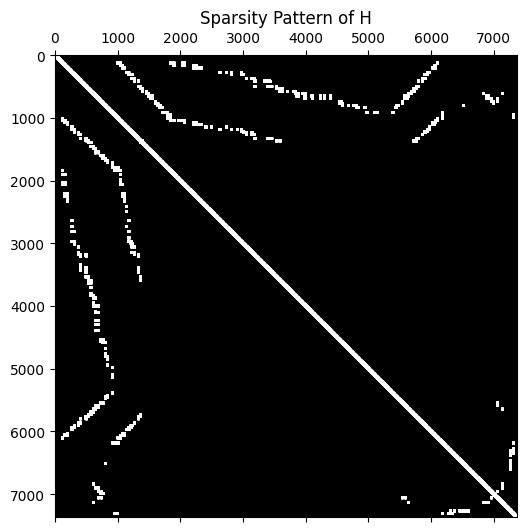

In [ ]:
"""
Main execution block.
Loads a g2o file, performs pose graph optimization, and visualizes the results.
"""

"""
  Dataset selection
"""
dataset_dir = "data"

# # Easy sequences
dataset_name = f"{dataset_dir}/input_INTEL_g2o.g2o"
# dataset_name = f"{dataset_dir}/input_M3500_g2o.g2o"
# dataset_name = f"{dataset_dir}/FR079_P_toro.graph"
# dataset_name = f"{dataset_dir}/CSAIL_P_toro.graph"
# dataset_name = f"{dataset_dir}/FRH_P_toro.graph"
# dataset_name = f"{dataset_dir}/parking-garage.g2o"
# dataset_name = f"{dataset_dir}/M10000_P_toro.graph"
# dataset_name = f"{dataset_dir}/cubicle.g2o"

# # Hard sequences, need rotation initialization (i.e., use_chordal_rotation_initialization=True)
# dataset_name = f"{dataset_dir}/sphere2500.g2o"
# dataset_name = f"{dataset_dir}/input_M3500b_g2o.g2o" #Extra Gaussian noise with standard deviation 0.2rad is added to the relative orientation measurements
# dataset_name = f"{dataset_dir}/input_MITb_g2o.g2o"

# TODO: these datasets still fail
# dataset_name = f"{dataset_dir}/grid3D.g2o"
# dataset_name = f"{dataset_dir}/rim.g2o"  # seems need SE(2) only weights

"""
  Pose-graph optimization
"""

# Using 1 (single-process) is okay because symforce's codegen-based compiled, optimized jacobian calculation is so fast.
#  and using bigger does not guarantee the faster speed because it reuiqres additional multi processing costs.
num_processes = 1

# if residual decrease is less than convergence_error_diff_threshold, early terminate.
max_iterations = 15

# initial robust kernel size
cauchy_c = 10.0

# recommend to use True (if False, using hand-written analytic Jacobian)
use_symforce_generated_jacobian = True

# rotation initialization (recommend to test for sphere2500, mandatory to use)
use_chordal_rotation_initialization = True

# visualization engine
visualize_using_open3d = (
    False  # if False, using plotly (may requires a few GB memories w.r.t datasets)
)

# iteration-wise debug
visualize3d_every_iteration = True  # if False, only draw the final result (a converted one or an iteratation-ended one)

# diagonal information (inverse of variance) of [t, r]
loop_information_matrix = np.diag([1.0, 1.0, 1.0, 100.0, 100.0, 100.0])
odom_information_matrix = np.diag([1.0, 1.0, 1.0, 100.0, 100.0, 100.0])

# PoseGraphOptimizer
pgo = PoseGraphOptimizer(
    max_iterations=max_iterations,
    initial_cauchy_c=cauchy_c,
    use_symforce_generated_jacobian=use_symforce_generated_jacobian,
    num_processes=num_processes,
    use_chordal_rotation_initialization=use_chordal_rotation_initialization,
    visualize_using_open3d=visualize_using_open3d,
    visualize3d_every_iteration=visualize3d_every_iteration,
    loop_information_matrix=loop_information_matrix,
    odom_information_matrix=odom_information_matrix,
)

# read data
poses_initial, edges = pgo.read_g2o_file(dataset_name)

# add initials
pgo.add_initials(poses_initial)

# add constraints
pgo.add_edges(edges)

# add prior
prior_node_idx = 0
pgo.add_prior(prior_node_idx)

# Optimize poses
poses_optimized = pgo.optimize()

# visualization (the final result)
pgo.visualize_3d_poses(pgo.get_optimized_poses(), "Final Result")